Opening raw data file C:\Users\Lab-User\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Loading data for 72 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch 

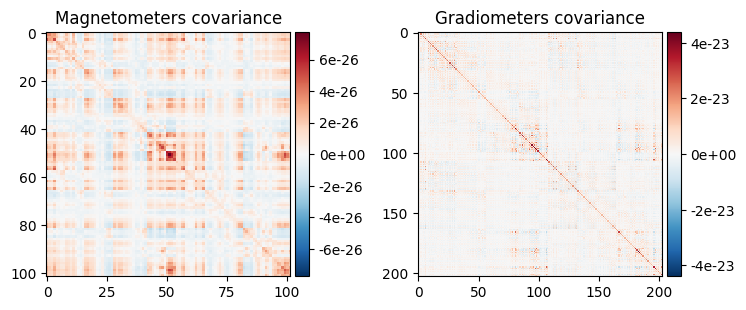

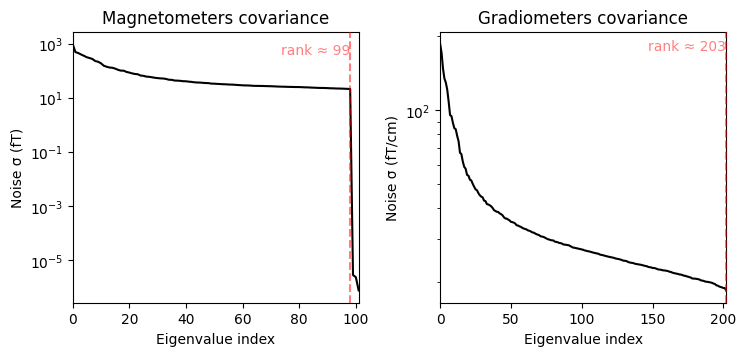

Loading data for 55 events and 106 original time points ...
Computing rank from data with rank=None
    Using tolerance 2.8e-09 (2.2e-16 eps * 305 dim * 4.2e+04  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 3)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 305 -> 302
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 1705
log-likelihood on unseen data (descending order):
   shrunk: -1466.449
   empirical: -1574.608
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.98  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None

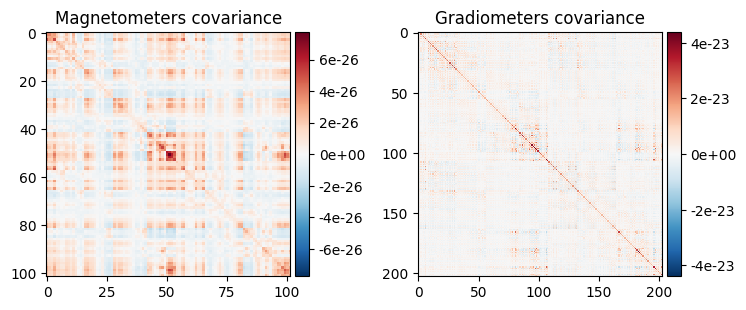

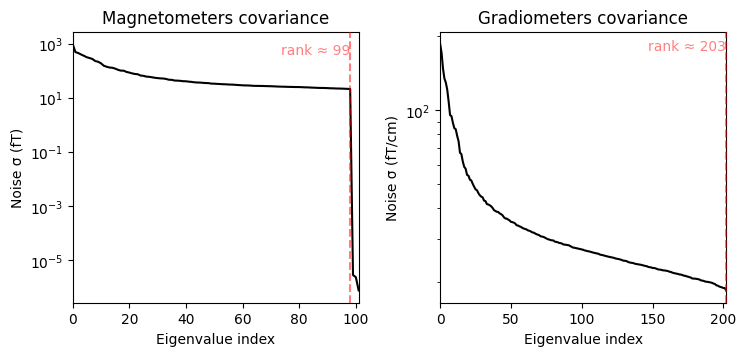

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


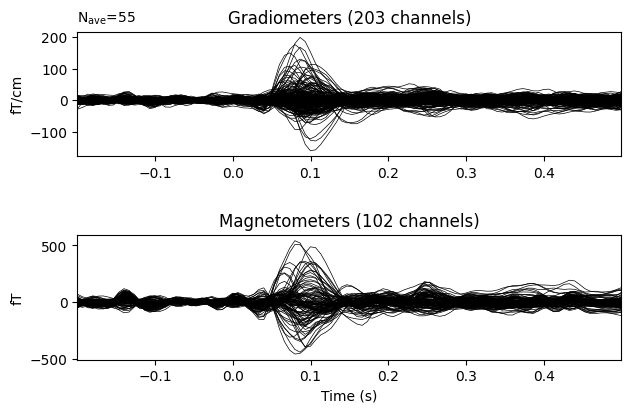

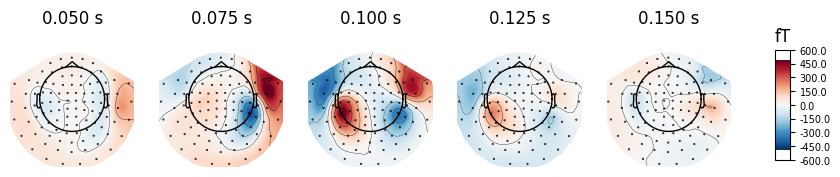

Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 203 dim * 3.5  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.98  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank={'grad': 203, 'mag': 99, 'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)


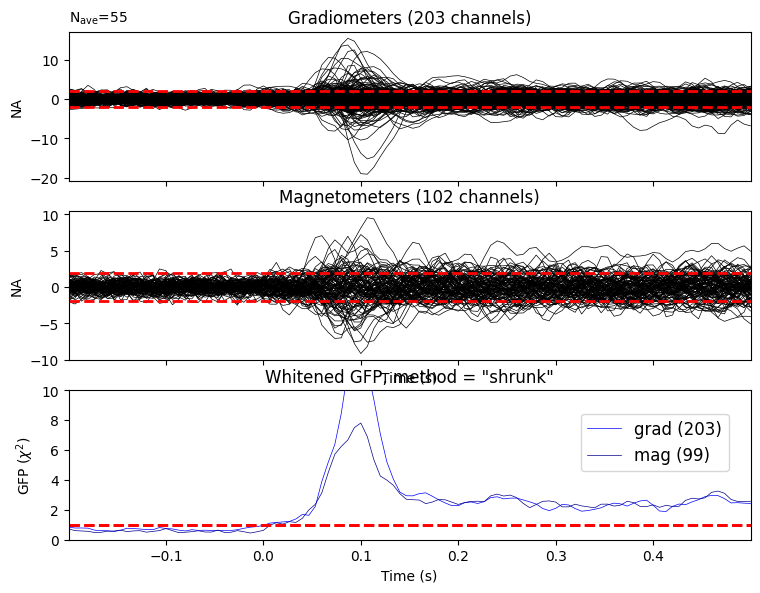

Reading forward solution from C:\Users\Lab-User\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
    305 out of 306 channels remai

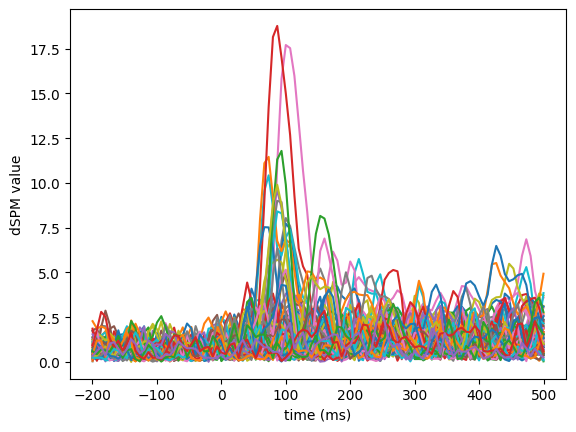

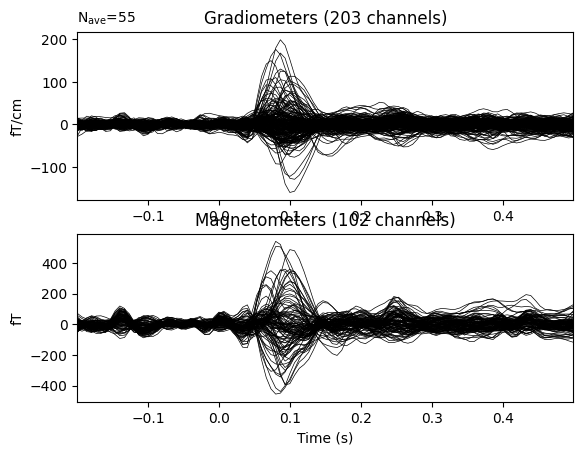

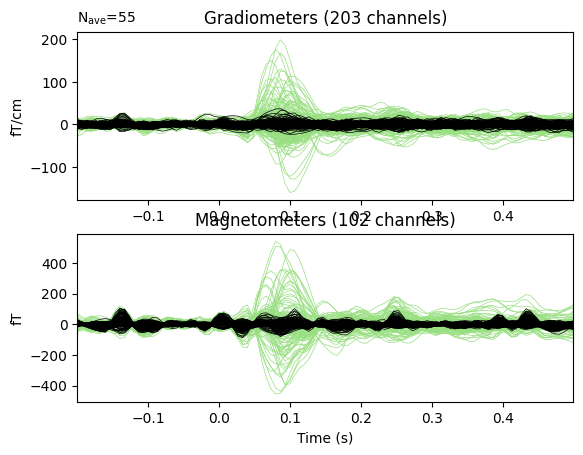

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse

data_path = sample.data_path()
raw_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014')

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('meg', 'eog'), baseline=baseline, reject=reject)


noise_cov = mne.compute_covariance(
    epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

noise_cov = mne.compute_covariance(
    epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

evoked = epochs.average().pick('meg')
evoked.plot(time_unit='s')
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag',
                    time_unit='s')
evoked.plot_white(noise_cov, time_unit='s')
del epochs, raw  # to save memory

fname_fwd = data_path / 'MEG' / 'sample' / 'sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd)

inverse_operator = make_inverse_operator(
    evoked.info, fwd, noise_cov, loose=0.2, depth=0.8)
del fwd

method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc, residual = apply_inverse(evoked, inverse_operator, lambda2,
                              method=method, pick_ori=None,
                              return_residual=True, verbose=True)

fig, ax = plt.subplots()
ax.plot(1e3 * stc.times, stc.data[::100, :].T)
ax.set(xlabel='time (ms)', ylabel='%s value' % method)
plt.show()

fig, axes = plt.subplots(2, 1)
evoked.plot(axes=axes)
for ax in axes:
    for text in list(ax.texts):
        text.remove()
    for line in ax.lines:
        line.set_color('#98df81')
residual.plot(axes=axes)

Using notebook 3d backend.



<IPython.core.display.Javascript object>


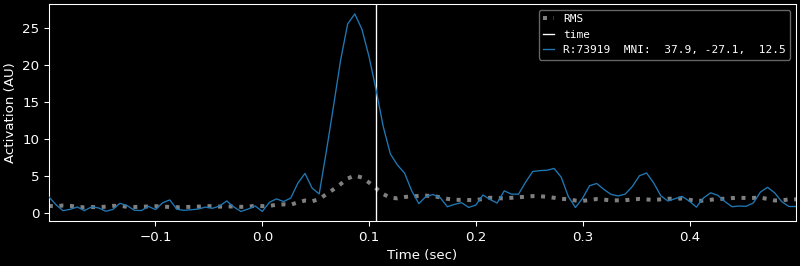

In [2]:
vertno_max, time_max = stc.get_peak(hemi='rh')

subjects_dir = data_path / 'subjects'
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
brain = stc.plot(**surfer_kwargs)
brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',
               scale_factor=0.6, alpha=0.5)
brain.add_text(0.1, 0.9, 'dSPM (plus location of maximal activation)', 'title',
               font_size=14)